In [1]:
#!pip install chainladder #pycaret optuna

# Machine Learning in Python



# Python Basics
## Importing Packages

The python standard library is useful for basic scripting of computer tasks, but it is not that great for data and analysis. 


In [1]:
import matplotlib.pyplot as plt
import chainladder as cl
import numpy as np
import pandas as pd

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

## The Scientific Python Stack
<img src="https://jupytearth.org/_images/python-stack.png" width="1000"/>

# The Basics
`sklearn` is the defacto standard Machine Learning  API in python. 

How do you get the most out of your data with Machine Learning with `sklearn`? An opinionated view:

| Technique | Return on Investment |
|-|-|
|Model selection|⭐⭐⭐⭐|
|Feature Preprocessing|⭐⭐|
|Feature Engineering|⭐⭐⭐⭐⭐|
|Hyperparameter tuning|⭐⭐⭐|
|Model Ensembling|⭐⭐⭐|


Let's explore the API.

## Estimators

Almost everything in `sklearn` is an estimator.  Estimators have properties that are worth remembering.

Estimators are python objects that carry out a Machine Learning task. These objects can do things (`fit`, `predict`) and have properties associated with them.

Depending on the algorithm you wish to use, you will need to import the specific `sklearn` class from which you'll create your estimator. This will typically follow the following structure:

```python
from some_module import Estimator
estimator = Estimator()
```
Estimators are instances of a class (which is denoted by Uppercase naming convention). Creating an instance of a model is as simple as adding parenthesis at the end of the class name.

Let's import the LinearRegression class and create an instance.

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model

LinearRegression()

👉 _All estimator objects can optionally be configured with **hyper**parameters to uniquely specify the model being built. This is done ahead of exposing any data to the model._

Hyperparameters are parameters that are set before the learning process of a machine learning algorithm. Unlike the model's parameters, which are learned from the data during training, hyperparameters are predefined and determined by the user or data scientist. These hyperparameters influence the behavior and performance of the learning algorithm.

```python
estimator = Estimator(param1=1, param2=2)
```

`sklearn` has sensible default hyperparameters. These can be viewed and optionally overridden.

In [4]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Note that we can set our **hyperparameters** in the absence of looking at any data. These parameters are there to tell the model how it should behave during the fitting process.

In [5]:
model = LinearRegression(fit_intercept=False)
model

LinearRegression(fit_intercept=False)

👉 _All estimator objects expose a `fit` method that takes as input, `X`_:

```python
estimator.fit(X, y)
```
Models also optionally support a response, `y` or and weights, `sample_weight`.


## Synthetic data
Let's create some _independent_ variables, **X** to explore the concept.

In [6]:
group = np.random.rand(200)
group = np.where(group<.4, 'a', np.where(group<.8, 'b', 'c'))
age = np.linspace(16, 100, 200)
X = pd.DataFrame({'group': group, 'age': age})
X.head()

,group,age
0,c,16.000000
1,b,16.422111
2,c,16.844221
3,b,17.266332
4,b,17.688442


Let's also syntehsize a _dependent_ variable, **y** that depends on the values of **X**.

In [9]:
y = 30 + X['group'].map({'a': 1.5, 'b': 1.0, 'c': 0.5}) * X['age'] + np.random.normal(0, 15, 200)
y[:5]

0    46.293010
1    53.732925
2    52.233393
3    37.760010
4    35.226075
dtype: float64

We know the linear equation that generated this data, but because we added an error term, we can see the _noise_ in our data.

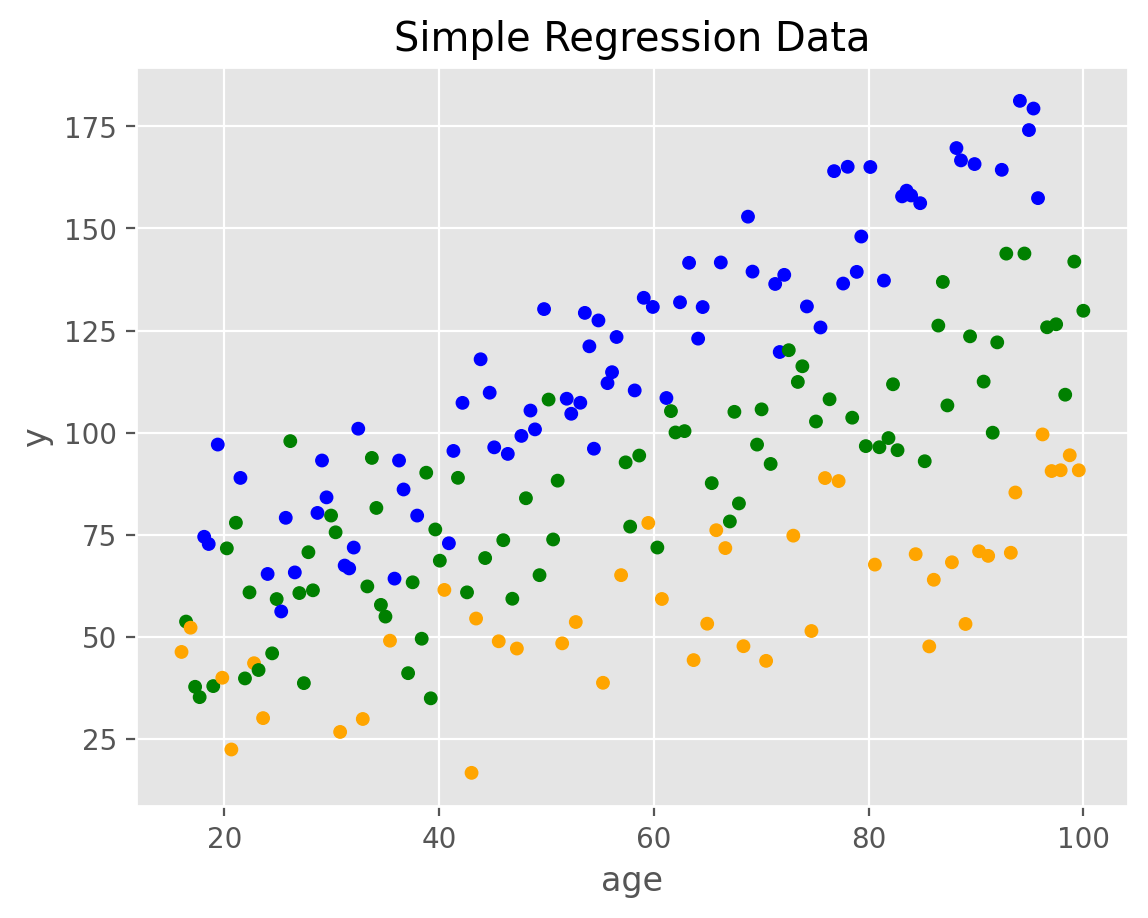

In [12]:
pd.concat((X, pd.Series(y, name='y')), axis=1).plot(
    kind='scatter', 
    x='age', y='y', 
    title='Simple Regression Data', 
    c=X['group'].map({'a': 'blue', 'b': 'green', 'c': 'orange'}));

## The `fit` method
Let's fit our model to our data just using `age`.

In [15]:
model = LinearRegression().fit(X[['age']], y)
model

LinearRegression()

It looks like nothing happened, but in actuality, our model has be fitted to the data.  The `model` object itself displays the same, but it now has additional features.  

👉 _When a model is fit, the fitted attributes are denoted by a trailing **underscore**._

```python
estimator.estimated_param_
```

The use of the underscore is a key API design style of scikit-learn that allows for the quicker recognition of fitted parameters vs hyperparameters:

In [16]:
f'The slope of the model is {model.coef_} and the intercept is {model.intercept_}.'

'The slope of the model is [0.90578149] and the intercept is 39.8496404195573.'

## The `score` method
Can we do statistical inference with `sklearn`?

Only in limited ways at an overall level. There are no coefficient-specific t-statistics, p-values, etc, associated with this model retained by `sklearn`. The machine learning focus of the library promotes overall model performance over and will have metrics for model accuracy, R-squared, AUC, etc.  

👉 _Scoring can only be invoked after a model has been `fit`._

By default regression problems use _R2_ as a scoring metric and classification uses _accuracy_. These can be changed and alternatives are found in the `sklearn.metrics` module.

In [18]:
print('Model R2:',  model.score(X[['age']], y))

Model R2: 0.3680809384052761


## The `predict` method

We can also make predictions with a fitted model using the `predict` method.

In [19]:
predictions = model.predict(X[['age']])
predictions[:10]

array([54.34214419, 54.72448412, 55.10682404, 55.48916397, 55.87150389,
       56.25384381, 56.63618374, 57.01852366, 57.40086358, 57.78320351])

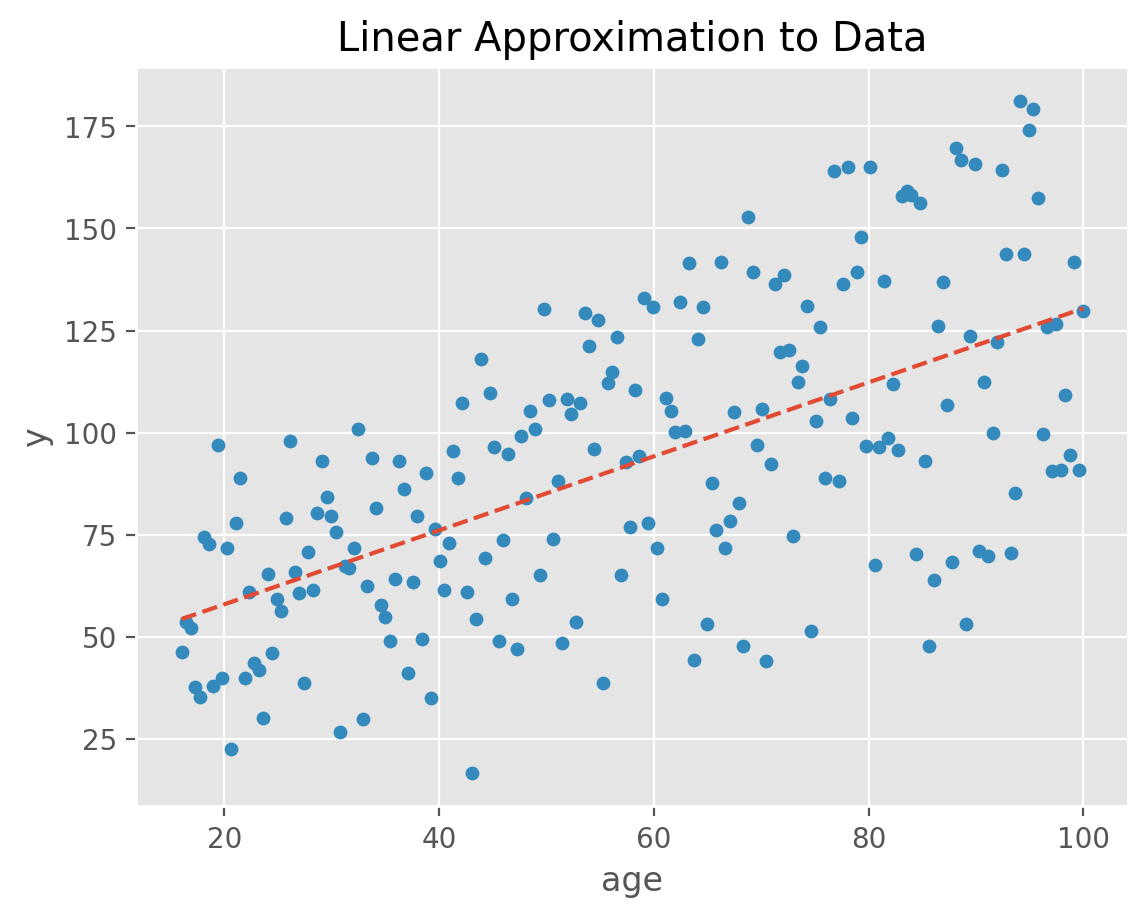

In [20]:
ax = pd.concat((X, pd.Series(y, name='y')), axis=1).plot(
    kind='scatter', x='age', y='y', 
    title='Linear Approximation to Data');

pd.concat(
    (X[['age']], pd.Series(predictions, name='y')),
    axis=1
).plot(
    kind='line', x='age', y='y',
    ax=ax, legend=False,
    linestyle='dashed');

Now let's try including `group`.

In [21]:
#model.fit(X, y)

## Transformers (Preprocessing)

`sklearn` comes with a a toolbox of preprocessing **Transformers** that can help specific algorithms react more appropriately to your data. Many algorithms have limitations. For example they may:
 * Can only deal with numeric values (OneHotEncoder or OrdinalEncoder)
 * Hate missing values (SimpleImputer or KNNImputer)
 * Use Euclidean distance for decision boundaries (StandardScaler)
 * Don't deal well with non-linear data (KBinsDiscretizer)
 * Don't explicitely recognize interactions (PolynomialFeatures)


A **Transformer** is just like the Estimators we learned about above with a couple of exceptions:
1. They transform our feature-space **X**
2. They have a `transform` method instead of a `predict` and `score` method.

We can see that the `linear_model` doesn't like categorical data.

In [44]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(X[['group']])

OneHotEncoder()

Once fit, transformers have fitted attributes (denoted by trailing underscore).

In [45]:
ohe.categories_

[array(['a', 'b', 'c'], dtype=object)]

We can then use our transform our featureset.

In [46]:
X['group'].head(), ohe.transform(X[['group']]).todense()[:5]

(0    c
 1    b
 2    c
 3    b
 4    b
 Name: group, dtype: object,
 matrix([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 0.]]))

In [47]:
X_transformed = pd.concat((
    pd.DataFrame(ohe.transform(X[['group']]).todense(), columns=ohe.categories_[0]),
    X['age']), axis=1)
X_transformed.head()

,a,b,c,age
0,0.0,0.0,1.0,16.000000
1,0.0,1.0,0.0,16.422111
2,0.0,0.0,1.0,16.844221
3,0.0,1.0,0.0,17.266332
4,0.0,1.0,0.0,17.688442


We can fit our model to this featureset, and see we get better performance.

In [48]:
model.fit(X_transformed, y)
model.score(X_transformed, y)

0.8270681117693042

Still, the form is not correct. This assumes each group and age are independent features. However, the source equation is an interaction between age and group.

In [49]:
pd.Series(model.coef_, index=model.feature_names_in_)

a      32.335887
b       0.633951
c     -32.969838
age     0.993957
dtype: float64

Let's also create the interaction terms we know are in the model (because we synthesized this data).

In [50]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pf.fit(X_transformed)


PolynomialFeatures(include_bias=False, interaction_only=True)

In [51]:
X_transformed = pd.DataFrame(
    pf.transform(X_transformed), 
    columns=pf.get_feature_names_out())
X_transformed.head()

,a,b,c,age,a b,a c,a age,b c,b age,c age
0,0.0,0.0,1.0,16.000000,0.0,0.0,0.0,0.0,0.000000,16.000000
1,0.0,1.0,0.0,16.422111,0.0,0.0,0.0,0.0,16.422111,0.000000
2,0.0,0.0,1.0,16.844221,0.0,0.0,0.0,0.0,0.000000,16.844221
3,0.0,1.0,0.0,17.266332,0.0,0.0,0.0,0.0,17.266332,0.000000
4,0.0,1.0,0.0,17.688442,0.0,0.0,0.0,0.0,17.688442,0.000000


We can now fit our model assuming the age:group interactions are the only relevant features.

In [53]:
model = LinearRegression().fit(X_transformed[['a age', 'b age', 'c age']], y)

In [54]:
print('Compared to true coefficients of [1.5, 1.0, 0.5], our model coefficients are', model.coef_)
print('Compared to true intercept of 30, our model coefficients are', model.intercept_)
print('Model R2:', model.score(X_transformed[['a age', 'b age', 'c age']], y))

Compared to true coefficients of [1.5, 1.0, 0.5], our model coefficients are [1.49174534 0.94815116 0.44771038]
Compared to true intercept of 30, our model coefficients are 32.90795397323727
Model R2: 0.8619670965579866


😩 These transformers are tedious. When new data comes in, the same transformations have to be applied to make a prediction.  

## Pipelines (Composite Estimators)

Piecing transformers and predictors together is a very common pattern and it is nice to do so succintly. With `Pipeline`s, one can create custom end-to-end models.

We do so by specifying a list of steps that should be executed in order.


In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pipe = Pipeline([
    ('group_transform', ColumnTransformer([('ohe', OneHotEncoder(), ['group']), ('pass', 'passthrough', ['age'])])),
    ('create_interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('retain_only_interactions', ColumnTransformer([('keep', 'passthrough', [6, 8, 9])])),
    ('model', LinearRegression())
])

Setting up a `Pipeline` can be complex, but once done, it makes everything else easier, like fitting:

In [59]:
pipe.fit(X, y)

Pipeline(steps=[('group_transform',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['group']),
                                                 ('pass', 'passthrough',
                                                  ['age'])])),
                ('create_interaction',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('retain_only_interactions',
                 ColumnTransformer(transformers=[('keep', 'passthrough',
                                                  [6, 8, 9])])),
                ('model', LinearRegression())])

scoring...

In [60]:
pipe.score(X, y)

0.8619670965579866

or making new predictions on raw data...

In [61]:
print(X.iloc[10:11])

print('prediction', pipe.predict(X.iloc[10:11]))

   group        age
10     b  20.221106
prediction [52.08061866]


Most importantly, `Pipeline`s encapsulate data transformations.

👉 _`Pipeline`s substantially minimize the risk of data leakage and are crucial for managing model generalization when preprocessing data is involved._


Let's look at the Regression Pipeline we created.

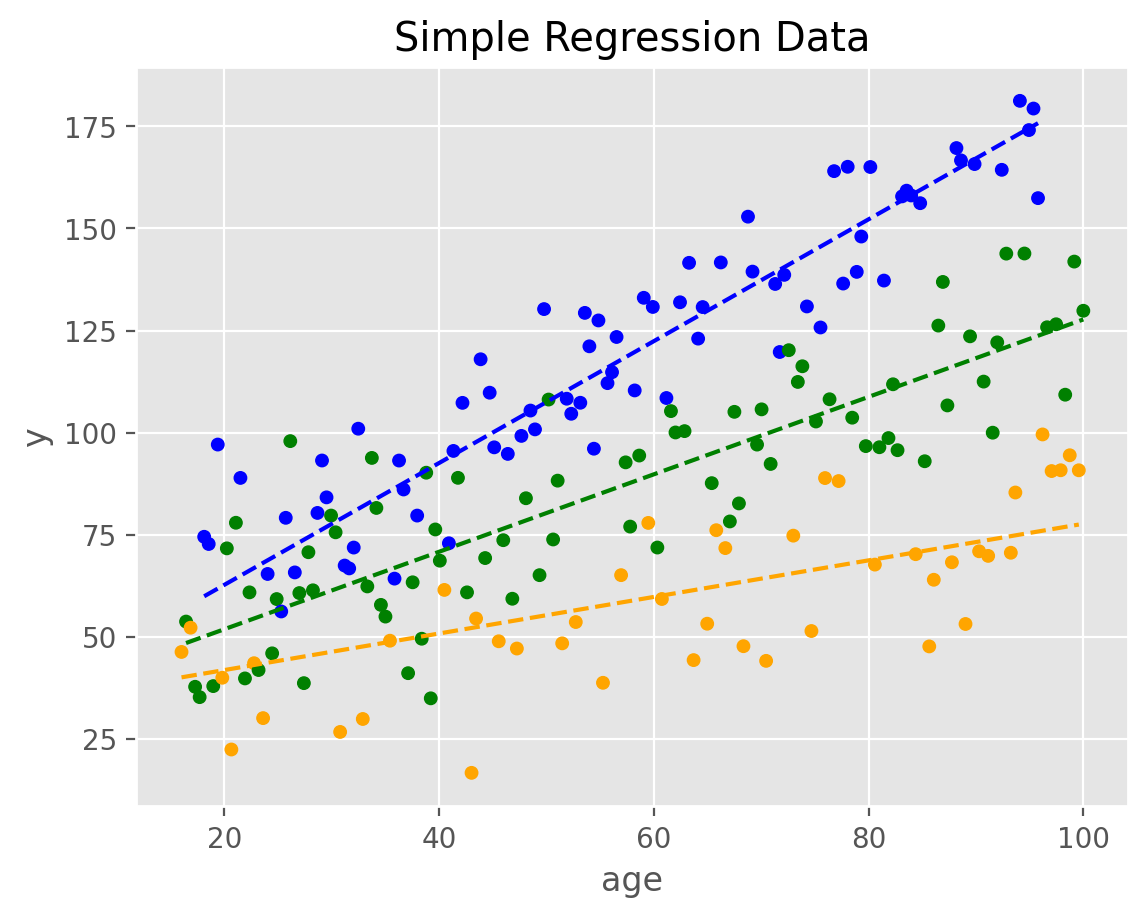

In [62]:
ax = pd.concat((X, pd.Series(y, name='y')), axis=1).plot(
    kind='scatter', 
    x='age', y='y', 
    title='Simple Regression Data', 
    c=X['group'].map({'a': 'blue', 'b': 'green', 'c': 'orange'})); 

pd.DataFrame({'age': X[X['group']=='a']['age'], 'y': pipe.predict(X[X['group']=='a'])}).plot(
    kind='line', x='age', y='y', ax=ax, legend=False, linestyle='dashed', color='blue');
pd.DataFrame({'age': X[X['group']=='b']['age'], 'y': pipe.predict(X[X['group']=='b'])}).plot(
    kind='line', x='age', y='y', ax=ax, legend=False, linestyle='dashed', color='green');
pd.DataFrame({'age': X[X['group']=='c']['age'], 'y': pipe.predict(X[X['group']=='c'])}).plot(
    kind='line', x='age', y='y', ax=ax, legend=False, linestyle='dashed', color='orange');

# A Classification Example

These are the very basics of `sklearn`, but let's try something on little more interesting with reserving triangles.

`sklearn` has estimators for clustering, classification, and regression. 



<img src="https://scikit-learn.org/stable/_static/ml_map.png" width="1000"/>


Diving deep into all areas is beyond the scope of this seminar. We will instead explore the scope of ML through a classification use-case.

**Can we determine the line of business of a loss triangle from the triangle itself?**


## The Dataset
### A `chainladder` Triangle

Let's explore the `clrd`  ([CAS Loss Reserve Database](https://www.casact.org/publications-research/research/research-resources/loss-reserving-data-pulled-naic-schedule-p)) dataset stored within the `chainladder` python package.

In [206]:
clrd = cl.load_sample('clrd')
clrd

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


We are using a `chainladder.Triangle` to explore the dataset.

In [207]:
type(clrd)

chainladder.core.triangle.Triangle

The `Triangle` object is like a pandas DataFrame with an individual triangle as a datatype.  We can have different rows of a triangle representing Companies and Lines of Business.  We can have different rows covering the different measures like Paid Loss, Premium, etc.  The result is a 4D object (Table of Triangles):


<img src="https://raw.githubusercontent.com/casact/chainladder-python/master/docs/images/triangle_graphic.PNG" width="1000" />

Our `clrd` triangle expressed as a DataFrame abstraction:

In [208]:
pd.DataFrame(
    index=clrd.index, 
    columns=list(clrd.columns), 
    data=np.repeat(np.repeat([[str(clrd.shape[2:])]], clrd.shape[0], axis=0), clrd.shape[1], axis=1)).head(10)

,IncurLoss,CumPaidLoss,BulkLoss,EarnedPremDIR,EarnedPremCeded,EarnedPremNet
"(Adriatic Ins Co, othliab)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Adriatic Ins Co, ppauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Aegis Grp, comauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Aegis Grp, othliab)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Aegis Grp, ppauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Agency Ins Co Of MD Inc, ppauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Agri General Ins Co, othliab)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Agway Ins Co, comauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Agway Ins Co, othliab)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"
"(Agway Ins Co, ppauto)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)","(10, 10)"


### Similarity to Pandas
The `Triangle` object is very similar to a pandas DataFrame and uses a subset of the pandas API for data manipulation. There are several advantages in having a dedicated Triangle object:

* Actuaries work with sets of triangles. DataFrames, being two dimensional, support single triangles with grace but become unwieldy with multiple triangles.
* We can carry through the meaningful pandas functionality while also supporting triangle specific methods not found in pandas
* Improved memory footprint with sparse array representation in backend
* Calculated fields with “virtual” columns allows for lazy column evaluation of Triangles as well as improved memory footprint for larger triangles.

Ultimately, there are a lot of things pandas can do that are not relevant to reserving, and there are a lot of things a Triangle needs to do that are not handled easily with pandas.  That said, a lot of pandas functionality works with Triangles.  For example, we can slice individual cells out of our table of Triangles by expressing a row and column combination. When looking at a single cell, we get the detailed representatin of that cell:

In [209]:
clrd.loc[('Agway Ins Co', 'comauto')]['CumPaidLoss']

,12,24,36,48,60,72,84,96,108,120
1988,72.00,122.00,142.00,156.00,167.00,175.00,180.00,181.00,184.00,184.00
1989,68.00,130.00,149.00,172.00,219.00,227.00,230.00,232.00,233.00,
1990,129.00,218.00,326.00,389.00,395.00,400.00,403.00,405.00,,
1991,365.00,536.00,574.00,676.00,692.00,763.00,790.00,,,
1992,155.00,226.00,310.00,550.00,589.00,623.00,,,,
1993,182.00,335.00,606.00,804.00,852.00,,,,,
1994,246.00,431.00,695.00,806.00,,,,,,
1995,226.00,362.00,386.00,,,,,,,
1996,174.00,252.00,,,,,,,,
1997,276.00,,,,,,,,,


We can calculate aggregate values over all "rows" of the `Triangle`:

In [210]:
clrd['CumPaidLoss'].sum()

,12,24,36,48,60,72,84,96,108,120
1988,"3,577,780","7,059,966","8,826,151","9,862,687","10,474,698","10,814,576","10,994,014","11,091,363","11,171,590","11,203,949"
1989,"4,090,680","7,964,702","9,937,520","11,098,588","11,766,488","12,118,790","12,311,629","12,434,826","12,492,899",
1990,"4,578,442","8,808,486","10,985,347","12,229,001","12,878,545","13,238,667","13,452,993","13,559,557",,
1991,"4,648,756","8,961,755","11,154,244","12,409,592","13,092,037","13,447,481","13,642,414",,,
1992,"5,139,142","9,757,699","12,027,983","13,289,485","13,992,821","14,347,271",,,,
1993,"5,653,379","10,599,423","12,953,812","14,292,516","15,005,138",,,,,
1994,"6,246,447","11,394,960","13,845,764","15,249,326",,,,,,
1995,"6,473,843","11,612,151","14,010,098",,,,,,,
1996,"6,591,599","11,473,912",,,,,,,,
1997,"6,451,896",,,,,,,,,


We can filter the triangle to a specific LOB.

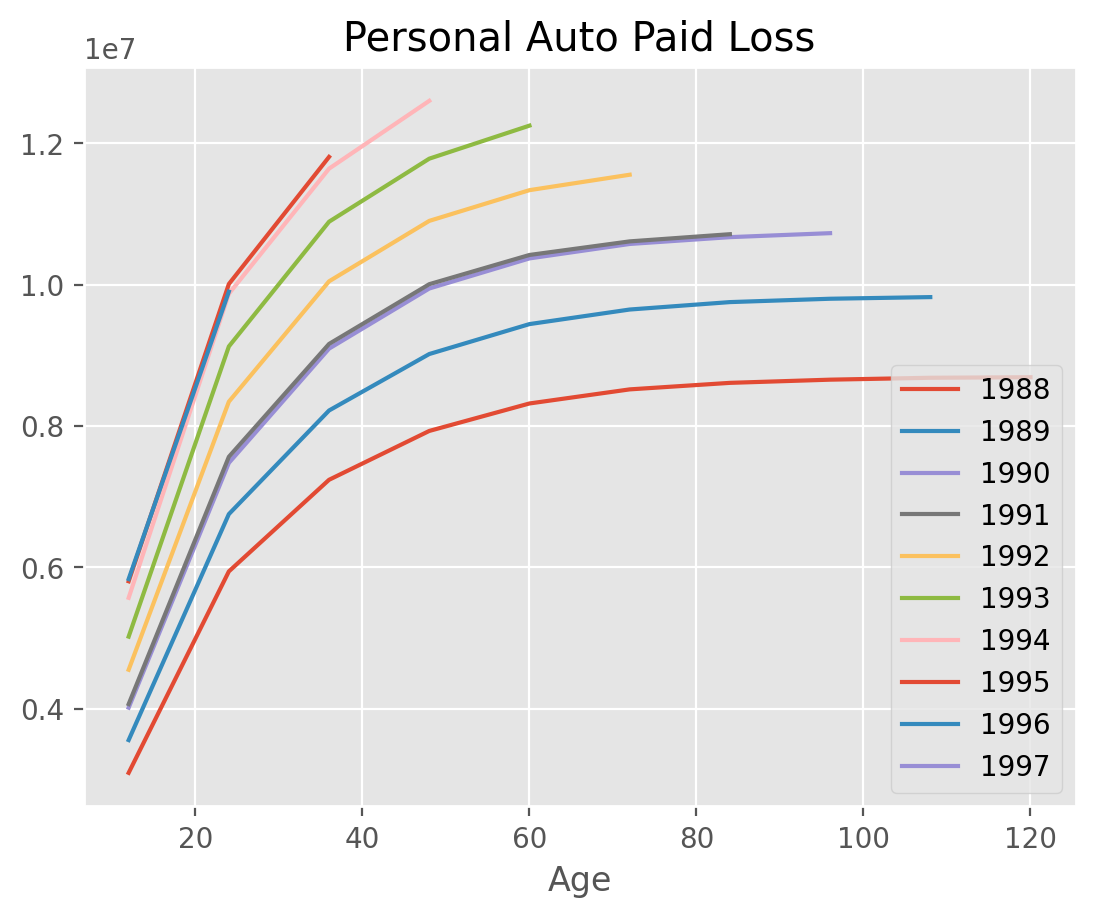

In [211]:
clrd[clrd['LOB']=='ppauto']['CumPaidLoss'].sum().T.plot(xlabel='Age', title='Personal Auto Paid Loss');

We can also do things that pandas doesn't support such as explore the age-to-age factors or `link_ratio` of any triangle.

In [212]:
clrd[clrd['LOB']=='ppauto']['CumPaidLoss'].sum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,1.9215,1.2181,1.0955,1.0490,1.0240,1.0108,1.0052,1.0031,1.0009
1989,1.8988,1.2171,1.0972,1.0470,1.0218,1.0109,1.0049,1.0024,
1990,1.8626,1.2162,1.0935,1.0428,1.0197,1.0091,1.0053,,
1991,1.8606,1.2111,1.0923,1.0413,1.0184,1.0096,,,
1992,1.8332,1.2041,1.0851,1.0399,1.0193,,,,
1993,1.8178,1.1934,1.0819,1.0397,,,,,
1994,1.7724,1.1794,1.0824,,,,,,
1995,1.7247,1.1797,,,,,,,
1996,1.6967,,,,,,,,


Creating a new column in a Triangle looks identical to the same operation in pandas.

In [213]:
clrd['CaseIncurLoss'] = clrd['IncurLoss'] - clrd['BulkLoss']
clrd

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 7, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet, CaseIncurLoss]"


### Feature Engineering

Feature engineering is the process of selecting, transforming, and creating new features from raw data to improve the performance of machine learning models. It is a crucial step in a machine learning as it can have a significant impact on the accuracy and effectiveness of the models.

The importance of feature engineering cannot be understated.  In deep learning frameworks, automatic feature engineering is one of the key reasons why it has become so powerful and successful in various machine learning tasks. Traditional machine learning algorithms often rely on handcrafted features, where domain experts manually engineer relevant features from raw data. However, this process can be time-consuming, error-prone, and may not capture all the underlying patterns in complex datasets.

`sklearn` is a traditional machine learning framework, so we are going to rely on our reserving expertise (and `chainladder`) to engineer features. As actuaries, we know that some lines of business are short-tailed and some are long-tailed. This information is encoded in the loss development patterns of a triangle. It makes sense that these patterns might also prove useful for a machine learning algorithm trying to predict line of business.

#### Link Ratios
`chainladder` has estimators that follow the sklearn convention too. We can define a model and fit it to some data.

We can define a model by creating an instance of a `chainladder` transformer. Here we take a simple average of link-ratios for each development age of a Triangle.

Here `cl.Development` is a `sklearn`-compliant estimator and `average` is a _hyperparameter_.

In [214]:
dev_model = cl.Development(average='simple')
dev_model

Development(average='simple')

Reserving is more like an unsupervised technique. We don't typically have a response variable, `y`.  Ignoring `y` is expected in `chainladder`, and for `sklearn` unsupervised techniques.

In [215]:
dev_model.fit(X=clrd['CumPaidLoss'])

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:58: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * y, axis) - xp.nansum(x * w, axis) * xp.nanmean(y, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:60: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * x, axis) - xp.nanmean(x, axis) * xp.nansum(w * x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:62: RuntimeWarning: Mean of empty slice
  intercept = xp.nanmean(y, axis) - slope * xp.nanmean(x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:115: RuntimeWarning: overflow encountered in exp
  fill_ = xp.exp(reg.x * slope + intercept) * (1 - w)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\dunders.py:307: RuntimeWarning: overflow encountered in square
  obj.values = xp.nan_to_num(obj

Development(average='simple')

Like sklearn, fitting our estimator exposes fitted parameters. The `Development` estimator has a `ldf_` parameter representing the selected age-to-age factors which are also represented by the `Triangle` object.

In [216]:
paid_link_ratios = dev_model.ldf_
paid_cdfs = dev_model.cdf_

paid_link_ratios

,Triangle Summary
Valuation:,2261-12
Grain:,OYDY
Shape:,"(775, 1, 1, 9)"
Index:,"[GRNAME, LOB]"
Columns:,[CumPaidLoss]


Like pandas we can slice into our Triangle to see a subset of the data.

In [217]:
paid_link_ratios.loc['Allstate Ins Co Grp'].loc['wkcomp']

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.3863,1.3624,1.1702,1.0901,1.0579,1.0461,1.0320,1.0348,1.0109


Let's derive the `ldf_` patterns for `CaseIncurLoss`:

In [218]:
inc_link_ratios = dev_model.fit(X=clrd['CaseIncurLoss']).ldf_
inc_cdfs = dev_model.cdf_

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:58: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * y, axis) - xp.nansum(x * w, axis) * xp.nanmean(y, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:60: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * x, axis) - xp.nanmean(x, axis) * xp.nansum(w * x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:62: RuntimeWarning: Mean of empty slice
  intercept = xp.nanmean(y, axis) - slope * xp.nanmean(x, axis)


In [219]:
inc_link_ratios.loc['Allstate Ins Co Grp'].loc['wkcomp']

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),1.3068,1.0507,1.0377,1.0181,1.0135,1.0128,1.0103,1.0105,0.9992


#### Paid to Incurred Ratio
The ratio of paid amounts to incurred amounts gives information on how fast claims are reported vs settled. A line like Workers' Compensation has fast reporting but slow settlement. Medical Malpractice might have slow reporting and slow settlement.

In [220]:
clrd['Paid-to-Incurred'] = clrd['CumPaidLoss'] / clrd['CaseIncurLoss']
paid_to_inc = clrd['Paid-to-Incurred'].mean(axis='origin')

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)


In [221]:
paid_to_inc.loc['Allstate Ins Co Grp'].loc['wkcomp']

,12,24,36,48,60,72,84,96,108,120
1988,0.3693,0.6401,0.7696,0.8351,0.8721,0.8968,0.9206,0.9363,0.9497,0.9599


#### Incremental Paid on Prior Case
Another variation on the paid to incurred is the incremental paid on prior case reserve. It measures what percentage of the prior year-end case reserves are paid out in the subsequent year.

In [222]:
clrd['CaseReserves'] = clrd['CaseIncurLoss'] - clrd['CumPaidLoss']

increm_paid_per_case = (
    clrd['CumPaidLoss'].cum_to_incr().iloc[..., 1:] / 
    clrd['CaseReserves'].iloc[..., :-1].values
).mean('origin')

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)


In [223]:
increm_paid_per_case.loc['Allstate Ins Co Grp'].loc['wkcomp']

,24,36,48,60,72,84,96,108,120
1988,0.7113,0.5042,0.4679,0.3790,0.3551,0.3741,0.3379,0.4096,0.2022


### Tidy Data

In order to explore this possibility, we need to **tidy** our dataset up.

1. Each variable in the dataset should be represented by its own column.
2. Each row in the dataset represents a separate observation or case. The dataset should contain individual records or instances, where each row corresponds to a unique observation.
3. Each cell in the dataset should hold a single value. This means that there should be no cells that contain multiple values or combine different types of information.

Our data now has one row per observation (triangle). There are 725 observations with 55 features where ach feature represents a origin/development combination from a 10 x 10 triangle.

In [224]:
paid_link_ratios = paid_link_ratios.to_frame()
paid_link_ratios.columns = [c + ' Paid Link Ratio' for c in paid_link_ratios.columns]

inc_link_ratios = inc_link_ratios.to_frame()
inc_link_ratios.columns = [c + ' Incurred Link Ratio' for c in inc_link_ratios.columns]

paid_to_inc = paid_to_inc.to_frame()
paid_to_inc.columns = [str(c) + ' Paid to Incurred' for c in paid_to_inc.columns]

increm_paid_per_case = increm_paid_per_case.to_frame()
increm_paid_per_case.columns = [str(c) + ' Incremental Paid to Prior Case' for c in increm_paid_per_case.columns]


paid_cdfs = paid_cdfs.to_frame()
paid_cdfs.columns = [c + ' Paid CDF' for c in paid_cdfs.columns]

inc_cdfs = inc_cdfs.to_frame()
inc_cdfs.columns = [c + ' Incurred CDF' for c in inc_cdfs.columns]

data = pd.concat([paid_link_ratios, inc_link_ratios, paid_to_inc, increm_paid_per_case, paid_cdfs, inc_cdfs], axis=1)
data.head()

12-24 Paid Link Ratio  24-36 Paid Link Ratio  \
GRNAME          LOB                                                     
Adriatic Ins Co othliab               0.000000               0.000000   
                ppauto                1.357143               1.000000   
Aegis Grp       comauto               2.625000               1.000000   
                othliab               0.000000               0.000000   
                ppauto                3.417789               1.222703   

                         36-48 Paid Link Ratio  48-60 Paid Link Ratio  \
GRNAME          LOB                                                     
Adriatic Ins Co othliab               0.000000               0.000000   
                ppauto                1.382353               1.000000   
Aegis Grp       comauto               1.000000               1.000000   
                othliab               0.000000               0.000000   
                ppauto                1.070270               1.023283   

                         60-72 Paid Link Ratio  72-84 Paid Link Ratio  \
GRNAME          LOB                                                     
Adriatic Ins Co othliab               0.000000               0.000000   
                ppauto                1.000000               1.000000   
Aegis Grp       comauto               1.000000               1.000000   
                othliab               0.000000               0.000000   
                ppauto                1.021659               1.006826   

                         84-96 Paid Link Ratio  96-108 Paid Link Ratio  \
GRNAME          LOB                                                      
Adriatic Ins Co othliab               0.000000                     0.0   
                ppauto                1.000000                     1.0   
Aegis Grp       comauto               0.000000                     0.0   
                othliab               0.000000                     0.0   
                ppauto                1.015241                     1.0   

                         108-120 Paid Link Ratio  12-24 Incurred Link Ratio  \
GRNAME          LOB                                                           
Adriatic Ins Co othliab                      0.0                   0.000000   
                ppauto                       1.0                   0.640034   
Aegis Grp       comauto                      0.0                   0.833333   
                othliab                      0.0                   0.000000   
                ppauto                       1.0                   1.060302   

                         ...  108-Ult Paid CDF  12-Ult Incurred CDF  \
GRNAME          LOB      ...                                          
Adriatic Ins Co othliab  ...               1.0             0.428571   
                ppauto   ...               1.0             0.596047   
Aegis Grp       comauto  ...               1.0             0.437500   
                othliab  ...               1.0             1.000000   
                ppauto   ...               1.0             1.126170   

                         24-Ult Incurred CDF  36-Ult Incurred CDF  \
GRNAME          LOB                                                 
Adriatic Ins Co othliab             0.428571             1.000000   
                ppauto              0.931274             0.905405   
Aegis Grp       comauto             0.525000             1.000000   
                othliab             1.000000             1.000000   
                ppauto              1.062122             0.922765   

                         48-Ult Incurred CDF  60-Ult Incurred CDF  \
GRNAME          LOB                                                 
Adriatic Ins Co othliab             1.000000              1.00000   
                ppauto              1.000000              1.00000   
Aegis Grp       comauto             1.000000              1.00000   
                othliab             1.000000              1.00000   
                ppau

### Removing sparse outliers
The `clrd` dataset has a lot of very sparse triangles that don't have any meaningful information in them.

In [225]:
clrd.loc['Adriatic Ins Co', 'CumPaidLoss'].loc['othliab']

,12,24,36,48,60,72,84,96,108,120
1988,,,,,,,,,,
1989,,,,,,,,,,
1990,,,,,,,,,,
1991,,,,,,,,,,
1992,,,,,,,,,,
1993,,,,,,,,,,
1994,,,,,,,,,,
1995,,,3.0000,,,,,,,
1996,,,,,,,,,,
1997,,,,,,,,,,


Let's exclude sparsely populated triangles where have the triangle entries or more are missing.

In [226]:
prem_density = np.minimum(clrd['EarnedPremDIR'], 1).sum('origin').sum('development').to_frame() / 55

In [227]:
data = data.loc[prem_density[prem_density>.5].index]
print(sum(prem_density<=0.5), 'records have been removed for being sparse.', sum(prem_density>0.5), 'have been retained.')

195 records have been removed for being sparse. 580 have been retained.


## Response encoding
As was the case with our featureset, our response variable needs to be numeric for it to work with several ML algorithms.

In [228]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data.index.get_level_values('LOB'))

LabelEncoder()

In [229]:
y = le.transform(data.index.get_level_values('LOB'))
print(le.classes_)
y[:10]

['comauto' 'medmal' 'othliab' 'ppauto' 'prodliab' 'wkcomp']


array([0, 3, 3, 0, 2, 3, 5, 0, 2, 4])

In [230]:
X = data.reset_index(drop=True)
X.head()

,12-24 Paid Link Ratio,24-36 Paid Link Ratio,36-48 Paid Link Ratio,48-60 Paid Link Ratio,60-72 Paid Link Ratio,72-84 Paid Link Ratio,84-96 Paid Link Ratio,96-108 Paid Link Ratio,108-120 Paid Link Ratio,12-24 Incurred Link Ratio,...,108-Ult Paid CDF,12-Ult Incurred CDF,24-Ult Incurred CDF,36-Ult Incurred CDF,48-Ult Incurred CDF,60-Ult Incurred CDF,72-Ult Incurred CDF,84-Ult Incurred CDF,96-Ult Incurred CDF,108-Ult Incurred CDF
0,2.625000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.833333,...,1.0,0.437500,0.525000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,3.417789,1.222703,1.070270,1.023283,1.021659,1.006826,1.015241,1.000000,1.0,1.060302,...,1.0,1.126170,1.062122,0.922765,1.007699,1.007490,1.002827,0.997036,1.000399,1.000000
2,1.875432,1.276395,1.035796,1.014925,1.002191,1.001576,1.000000,0.000000,0.0,1.022153,...,1.0,0.990479,0.969012,0.991839,0.991406,0.993123,0.993309,1.000000,1.000000,1.000000
3,1.651714,1.341983,1.269221,1.085579,1.051484,1.021168,1.006405,1.010442,1.0,1.245743,...,1.0,1.732791,1.390970,1.200159,1.145194,1.111696,1.080945,1.082176,1.083142,1.080569
4,3.277381,7.487689,1.337044,1.490741,1.000000,1.000000,0.968992,1.000000,1.0,1.789951,...,1.0,0.637798,0.356322,0.480133,0.947312,1.007752,0.968992,0.968992,1.000000,1.000000


## Data Splitting

The train-test split is a crucial step in the machine learning process, and it serves the improtant purpose of testing whether our models generalize well. Overfitting occurs when a model performs well on the training data but fails to generalize to new data. By evaluating the model on a separate test set, you can assess whether it has learned to capture meaningful patterns or if it is merely memorizing the training data. This helps in detecting and mitigating overfitting issues.

There are several splitting strategies available, but we will use a simple random splitter with 75% in training and 25% in test.

In [231]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size = 0.25, random_state = 41)

## Our First Model

Let's start with the `KNeighborsClassifier`. It works based on the idea that similar data points tend to have similar labels or target values.

In [232]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
print(f'Model Training Accuracy: {knn_model.score(X_train, y_train)}')

Model Training Accuracy: 0.6068965517241379


Let's also try a `RandomForestClassifier` which is an ensemble method that combines multiple decision trees to make a prediction.

In [233]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print(f'Model Training Accuracy: {rf_model.score(X_train, y_train)}')

Model Training Accuracy: 0.9954022988505747


In classification problems, looking beyond accuracy at precision, recall, and F1 score is informative, especially for multinomial classification. These are difficult to remember terms, but are nicely encapsualted in the `confusion_matrix` which is a matrix of actual classification vs predicted classification.

In [234]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(y_train, rf_model.predict(X_train)),
    index=le.classes_,
    columns=le.classes_)
cm.style.background_gradient(cmap='Blues', axis=1)

,comauto,medmal,othliab,ppauto,prodliab,wkcomp
comauto,88,0,0,0,1,0
medmal,0,11,0,0,0,0
othliab,0,0,143,0,1,0
ppauto,0,0,0,86,0,0
prodliab,0,0,0,0,35,0
wkcomp,0,0,0,0,0,70


Accuracy is just sum of the diagonal of the confusion matrix over all entries in the confusion matrix.

In [235]:
print(f'Model Training Accuracy: {np.diag(cm).sum() / cm.sum().sum()}')

Model Training Accuracy: 0.9954022988505747


This is amazing accuracy! But we're skeptical that it is representative of how good the model will perform on our test dataset.  That said, we don't want to look at our test dataset because if we use performance on test to refine our model, then we are leaking information from our test set back into training.

👉 _Never look at your holdout dataset until you are done with all training iterations of your models._

We overcome this issue with cross-validation on our training dataset.

## Cross Validation
We can use cross-validation to emulate the results expected on a true holdout set.
![](https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif)

In `sklearn`, this is achieved by passing the estimator and the data into the `cross_val_score` function. `cross_val_score` defaults to 5 80/20 random splits of our training data. It trains on the 80% and tests on the 20%.

In [236]:
from sklearn.model_selection import KFold, cross_validate

cv=KFold(n_splits=5, shuffle=True)
cv

KFold(n_splits=5, random_state=None, shuffle=True)

In [237]:
rf_cv_score = cross_validate(rf_model, X_train, y_train, cv=cv)
print(rf_cv_score['test_score'])
print('Average Cross-Validated Accuracy:', rf_cv_score['test_score'].mean())

[0.59770115 0.56321839 0.52873563 0.56321839 0.50574713]
Average Cross-Validated Accuracy: 0.5517241379310345


This is woefully short of the accuracy on the training data. Is our model providing any value at all?  It's certainly better than KNeighbors.

In [238]:
knn_cv_score = cross_validate(KNeighborsClassifier(), X_train, y_train, cv=cv)
print(f'KNeighbors Cross-Validated Accuracy:', knn_cv_score['test_score'].mean())

KNeighbors Cross-Validated Accuracy: 0.4735632183908047


## The NULL Model

We can randomly guess a classification and (assuming data is evenly distributed) expect 1/6 or 17% accuracy from change. However, our data is not evenly distributed.

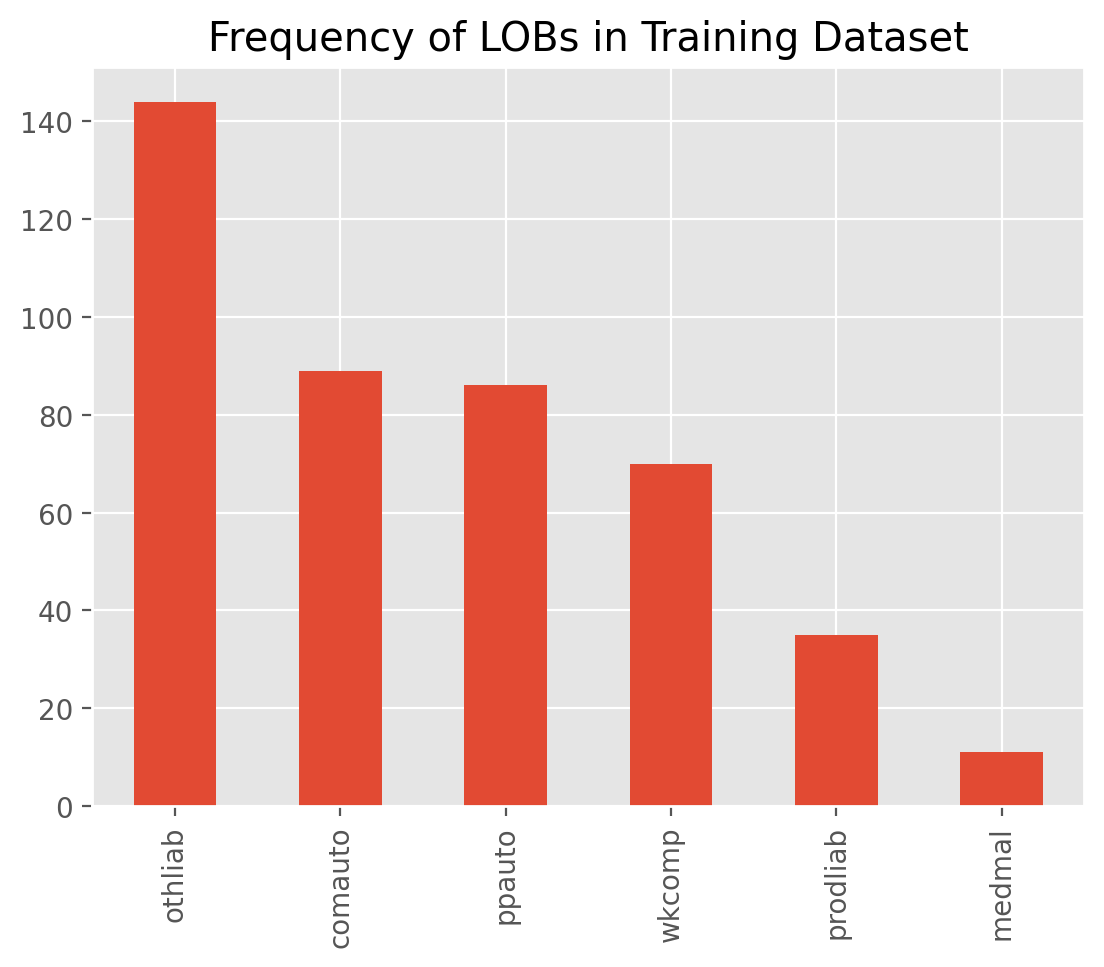

In [239]:
pd.Series(le.inverse_transform(y_train)).value_counts().plot(kind='bar', title='Frequency of LOBs in Training Dataset');

We can use `sklearn`s Dummy estimators to find out. Like all other estimators, it conforms to the same API and can be used with cross-validation, pipelines, etc.

In [240]:
from sklearn.dummy import DummyClassifier
dummy_model_cv = cross_validate(DummyClassifier(), X_train, y_train, cv=cv)

print("Dummy Accuracy:", dummy_model_cv['test_score'].mean())

Dummy Accuracy: 0.3310344827586207


Consider an extreme example often found in rare medical diagnoses or fraud detection. Note, in this case, _accuracy_ is probably not the most valuable measure of model performance.

Dummy Accuracy on highly imbalanced data: 0.984


Our RandomForestClassifier is better than the DummyClassifer, so its providing at least some value, but is it the best it can be? 

## Parameter Tuning
`sklearn` has sensible defaults for hyperparameters, but changing these will alter how the model works and ultimately will have consequences for model performance. `GridSearchCV` is a very simple and brute-force approach to testing various hyperparameters.  It is effectively a loop over all hyperparameters you want to test (as specified by `param_grid`).

In [241]:
%%time
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]},
    cv=cv)

rf_grid.fit(X_train, y_train)

CPU times: total: 34.7 s
Wall time: 34.8 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]})

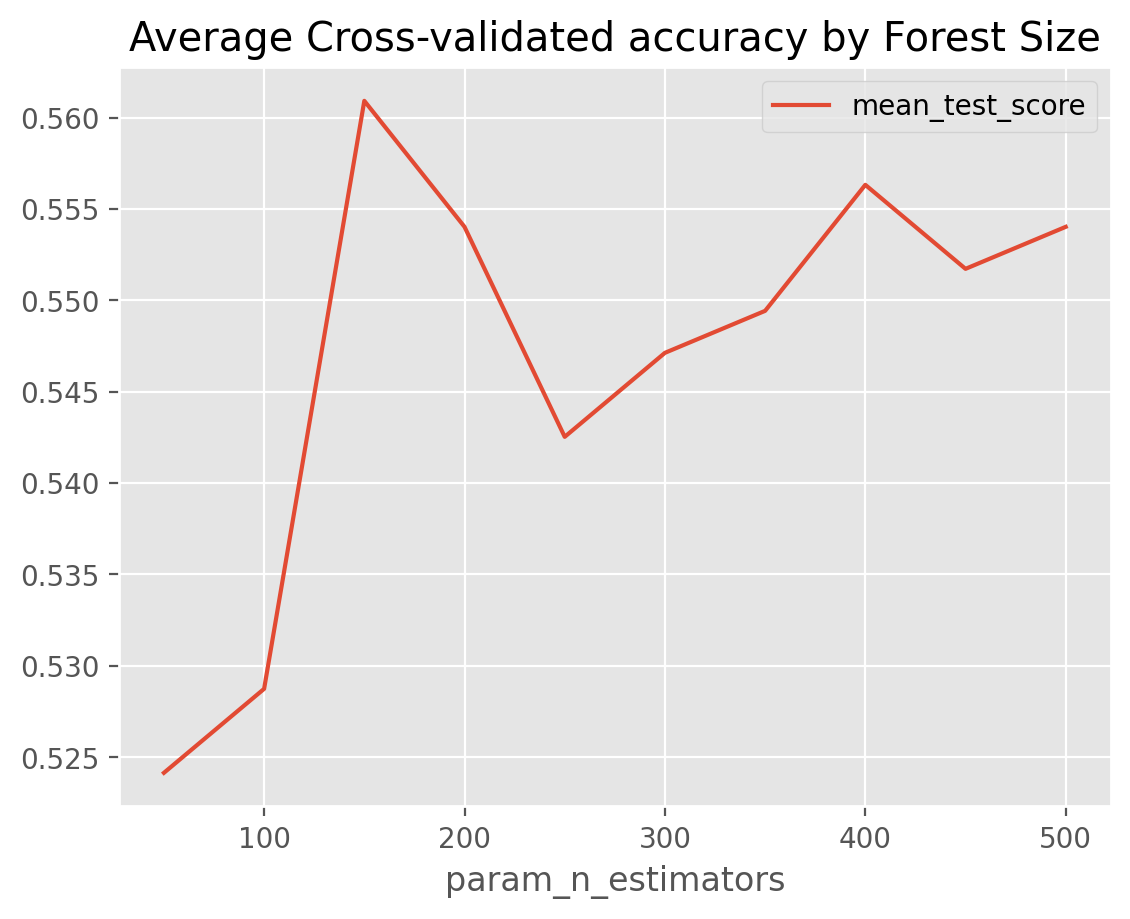

In [242]:
pd.DataFrame(rf_grid.cv_results_).set_index('param_n_estimators')[['mean_test_score']].plot(
    title='Average Cross-validated accuracy by Forest Size');

When tuning more than one hyperparameter, `GridSearchCV` will fit each unique combination of your parameter grid.  Here we have 1x4x3=12 parameter sets, cross-validated 5 times, yields 60 models.  

In [243]:
%%time
rf_grid = GridSearchCV(
    RandomForestClassifier(), 
    param_grid={
        'class_weight': ['balanced'],
        'n_estimators': [250, 500, 750, 1000],
        'max_depth': [10, 20, 30],})

rf_grid.fit(X_train, y_train)

CPU times: total: 1min 38s
Wall time: 1min 38s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [250, 500, 750, 1000]})

In [244]:
pd.pivot_table(
    data=pd.DataFrame(rf_grid.cv_results_), 
    index=['param_n_estimators'], 
    columns='param_max_depth', 
    values='mean_test_score'
).style.background_gradient(cmap='Blues', axis=None)

param_max_depth,10,20,30
param_n_estimators,,,
250,0.556322,0.560920,0.556322
500,0.556322,0.558621,0.558621
750,0.560920,0.549425,0.560920
1000,0.558621,0.551724,0.551724


In [245]:
tuned_rf_cv_score = cross_validate(rf_grid.best_estimator_, X_train, y_train, cv=cv)
print(f'Our Tuned Model accuracy:', tuned_rf_cv_score['test_score'].mean())

Our Tuned Model accuracy: 0.5471264367816092


`GridSeachCV` is horribly inefficient. That said, the approach of testing various hyperparameters is fundamentally how all hyperparameter optimization routines work. Other routines will only run combinations that are likely to produce model improvement.  For further reference, see `sklearn` documentation of [Hyperparameter Optimizers](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers)
or third-party packages such as [Optuna](https://optuna.org/) or [Hyperopt](http://hyperopt.github.io/hyperopt/) for more scalable approaches.

## Gradient Boosted Machines (GBM)

In recent years, gradient boosted machine, specifically libraries like LightGBM and XGBoost, have become increasingly popular in the field of machine learning and data science. They tend to be more robust to many ML painpoint such as:
1. imbalanced data (classification)
2. computational efficiency
3. missing data
4. outliers
5. Non-linear relationships
6. accuracy

Much of the `Pipeline` preprocessing work we did in "The Basics" with Linear Models become much less important with GBM. As modeling competitions go for tabular data, GBM dominates the rankings.


These libraries are also completely compatible with the `sklearn` API.

In [246]:
from lightgbm import LGBMClassifier

gbm_cv_score = cross_validate(LGBMClassifier(), X_train, y_train, cv=cv)
print(f'Our Tuned Model accuracy:', gbm_cv_score['test_score'].mean())

Our Tuned Model accuracy: 0.535632183908046


Like `sklearn`-native estimators, they can be tuned as well.

In [247]:
%%time
gbm_grid = GridSearchCV(
    LGBMClassifier(), 
    param_grid={
        'num_leaves': [2, 5, 10, 15],
        'learning_rate': [.01, .1],
        'reg_alpha': [.5, 1],
        'reg_lambda': [0, .5,]})

gbm_grid.fit(X_train, y_train)

CPU times: total: 3min 8s
Wall time: 25.9 s


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'num_leaves': [2, 5, 10, 15], 'reg_alpha': [0.5, 1],
                         'reg_lambda': [0, 0.5]})

In [248]:
pd.pivot_table(pd.DataFrame(gbm_grid.cv_results_), 
               index=['param_num_leaves', 'param_learning_rate'], 
               columns=['param_reg_alpha', 'param_reg_lambda'], 
               values='mean_test_score', aggfunc='mean'
              ).style.background_gradient(cmap='Blues', axis=None)

In [249]:
tuned_gbm_cv_score = cross_validate(gbm_grid.best_estimator_, X_train, y_train, cv=cv)
print('LightGBM Tuned Model accuracy:', tuned_gbm_cv_score['test_score'].mean())

LightGBM Tuned Model accuracy: 0.5609195402298852


## Ensembling

Another strategy to improve ML performance is to blend multiple algorithms together. Different algorithms have differing strengths and weaknesses.  Combining the effects of different models can help 

In [250]:
from sklearn.ensemble import StackingClassifier

sc = StackingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier()),
        ('rf', RandomForestClassifier(class_weight='balanced')),
        ('gbm', LGBMClassifier(class_weight='balanced'))])

sc.fit(X_train, y_train)

StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced')),
                               ('gbm',
                                LGBMClassifier(class_weight='balanced'))])

In [251]:
stacked_cv_score = cross_validate(sc, X_train, y_train, cv=cv)
stacked_cv_score['test_score'].mean()

0.535632183908046

As with all other Estimators, Ensembles also support hyperparameter optimization. In order to avoid hyperparameter name clashes between different sub-estimators, 

_👉 `StackingClassifier` and `Pipeline` use a **double underscore** convention to separate the sub-estimator name and hyperparameter name._

In this way, we are not optimizing any one model, but the entire ensemble.

In [252]:
%%time
stack_grid = GridSearchCV(
    sc, 
    param_grid={
        'knn__n_neighbors': [3, 8],
        'rf__max_depth': [10, 30],
        'gbm__num_leaves': [5, 15]})

stack_grid.fit(X_train, y_train)

CPU times: total: 10min 56s
Wall time: 2min 27s


GridSearchCV(estimator=StackingClassifier(estimators=[('knn',
                                                       KNeighborsClassifier()),
                                                      ('rf',
                                                       RandomForestClassifier(class_weight='balanced')),
                                                      ('gbm',
                                                       LGBMClassifier(class_weight='balanced'))]),
             param_grid={'gbm__num_leaves': [5, 15], 'knn__n_neighbors': [3, 8],
                         'rf__max_depth': [10, 30]})

In [253]:
tuned_stacked_cv_score = cross_validate(stack_grid.best_estimator_, X_train, y_train, cv=cv)
tuned_stacked_cv_score['test_score'].mean()

0.5517241379310346

## Model Generalization

At this point, we are seeing diminishing returns with our experiments. We've used `cross_val_score` as a proxy for whether our model will generalize well.  On that basis, the tuned LightGBM model provides the greatest accuracy.


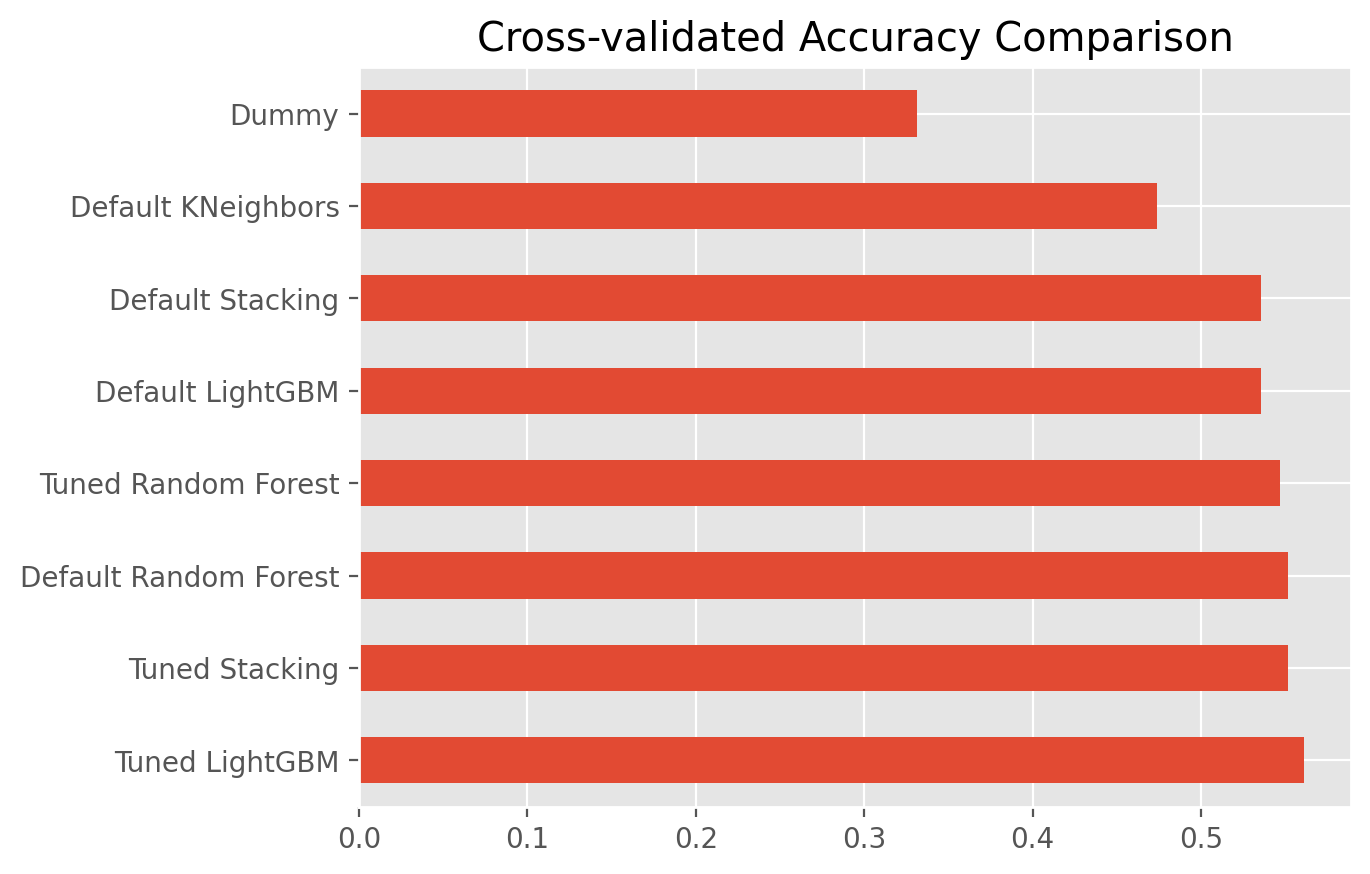

In [254]:
pd.Series({
    'Dummy': dummy_model_cv['test_score'].mean(), 
    'Default KNeighbors': knn_cv_score['test_score'].mean(),
    'Default Random Forest': rf_cv_score['test_score'].mean(), 
    'Tuned Random Forest': tuned_rf_cv_score['test_score'].mean(),
    'Default LightGBM': gbm_cv_score['test_score'].mean(),
    'Tuned LightGBM': tuned_gbm_cv_score['test_score'].mean(),
    'Default Stacking': stacked_cv_score['test_score'].mean(),
    'Tuned Stacking': tuned_stacked_cv_score['test_score'].mean()
}).sort_values(ascending=False).plot(kind='barh', title='Cross-validated Accuracy Comparison');

### Performance on Test

We should expect our cross-validated performance to be similar to our holdout performance if:
1. Train/Test Split data distributions are not biased
2. There is no data leakage between Train/Test

In [126]:
gbm_grid.best_estimator_.score(X_test, y_test)

0.4381443298969072

In [127]:
cm = pd.DataFrame(
    confusion_matrix(y_test, gbm_grid.best_estimator_.predict(X_test)),
    index=le.classes_,
    columns=le.classes_)
cm.style.background_gradient(cmap='Blues', axis=1)

,comauto,medmal,othliab,ppauto,prodliab,wkcomp
comauto,10,1,19,8,0,1
medmal,0,1,6,0,0,0
othliab,5,2,40,8,0,3
ppauto,7,0,4,18,0,3
prodliab,2,0,18,0,0,0
wkcomp,3,0,14,5,0,16


### Know your metric
'prodliab' and 'medmal' are disproportionately classed as 'othliab'. This is a very common problem with imbalanced datasets. Underrepresented classes tend to perform poorly when optimizing for _accuracy_. In cases such as fraud detection accuracy would not be the best measure of model success.

How does one deal with imbalanced data?
- Some of the algorithms we explored `RandomForestClassifier` and `LGBMClassifier` have a `class_weight` hyperparameter that can be set to 'balanced'.
- Some algorithms support a `sample_weight` in the `fit` method. `model.fit(X, y, sample_weight=...)` this can also be used to give more weight to certain observations.
- Other packages like [imbalanced-learn](https://imbalanced-learn.org/stable/) are `sklearn` compatible packages that add additional functionality to address class imbalance.

In all cases, you will likely use another metric (like Precision, Recall, F1, ROC) to gauge which model and hyperparameter set are the msot appropriate.


Consider an extremely imbalanced binary classification problem:

In [271]:
X_imbalanced = np.random.rand(500, 20) # 20 columns of random uniform numbers
y_imbalanced = (np.random.rand(500)<.01)*1 # 1% of response variable is 1 99% is 0.

print('Dummy Accuracy on highly imbalanced data:', cross_validate(DummyClassifier(), X_imbalanced, y_imbalanced, cv=cv)['test_score'].mean())

Dummy Accuracy on highly imbalanced data: 0.986


One simply needs to pass the `scoring` argument to `GridSeachCV` and/or `cross_validate` to chose a different scoring mechanism.

In [1129]:
rf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={'n_estimators': [100, 500]},
    scoring='f1_weighted', # change the scoring algorithm from accuracy to F1
    cv=cv)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='f1_weighted')

In [1135]:
print('Default Random Forest F1:', cross_validate(RandomForestClassifier(), X_train, y_train, cv=cv, scoring='f1_weighted')['test_score'].mean())
print('Tuned Random Forest F1:', cross_validate(rf_grid.best_estimator_, X_train, y_train, cv=cv, scoring='f1_weighted')['test_score'].mean())

Default Random Forest F1: 0.5458147410640284
Tuned Random Forest F1: 0.5716941162651222


## Model Explainability

Model explainability is crucial for for several reasons. It aids the practitioner in identifying weaknesses in the model. It promotes refinement in feature engineering.  It promotes the discovery of _bias_ and _ethical_ concerns in the model. It's key for communicating what drives the model decisions and gaining stakeholder trust.

### Feature Importance

Feature importance is built into several algorithms. In particular the tree-based algorithms include this attribute and it shows the relative importance or contribution of each feature in a machine learning model's predictions.

For tree-based models, such as Decision Trees and Random Forests, feature importance is usually computed based on how much each feature contributes to reducing impurity or variance across the trees. The more a feature is used to split the data and the more it reduces the impurity, the higher its importance.

In GBMs, feature importance is determined by the average improvement in the model's loss function (e.g., mean squared error or log loss) that is achieved when a particular feature is used for splitting during the boosting process.

In [132]:
pd.Series(rf_grid.best_estimator_.feature_importances_, index=rf_grid.best_estimator_.feature_names_in_).sort_values(ascending=False).head(10)

12 Paid to Incurred                  0.067647
12-24 Paid Link Ratio                0.043378
12-Ult Paid CDF                      0.043195
24 Paid to Incurred                  0.041705
24-36 Paid Link Ratio                0.036194
24-Ult Paid CDF                      0.034106
24 Incremental Paid to Prior Case    0.033210
36-48 Paid Link Ratio                0.029967
36 Paid to Incurred                  0.029083
24-36 Incurred Link Ratio            0.027545
dtype: float64

In [133]:
pd.Series(gbm_grid.best_estimator_.feature_importances_, index=gbm_grid.best_estimator_.feature_name_).sort_values(ascending=False).head(10)

12-24_Paid_Link_Ratio                218
12_Paid_to_Incurred                  199
24-36_Paid_Link_Ratio                172
36-48_Paid_Link_Ratio                169
24-Ult_Paid_CDF                      108
24_Incremental_Paid_to_Prior_Case     95
24-36_Incurred_Link_Ratio             92
12-Ult_Paid_CDF                       87
36-48_Incurred_Link_Ratio             86
48-60_Paid_Link_Ratio                 85
dtype: int32

### Partial Dependence
Partial dependence of a feature provide a global view of the feature's impact, averaging across all instances in the dataset. In multiclassification, these plots show the probability of of the target class along a univariate view.

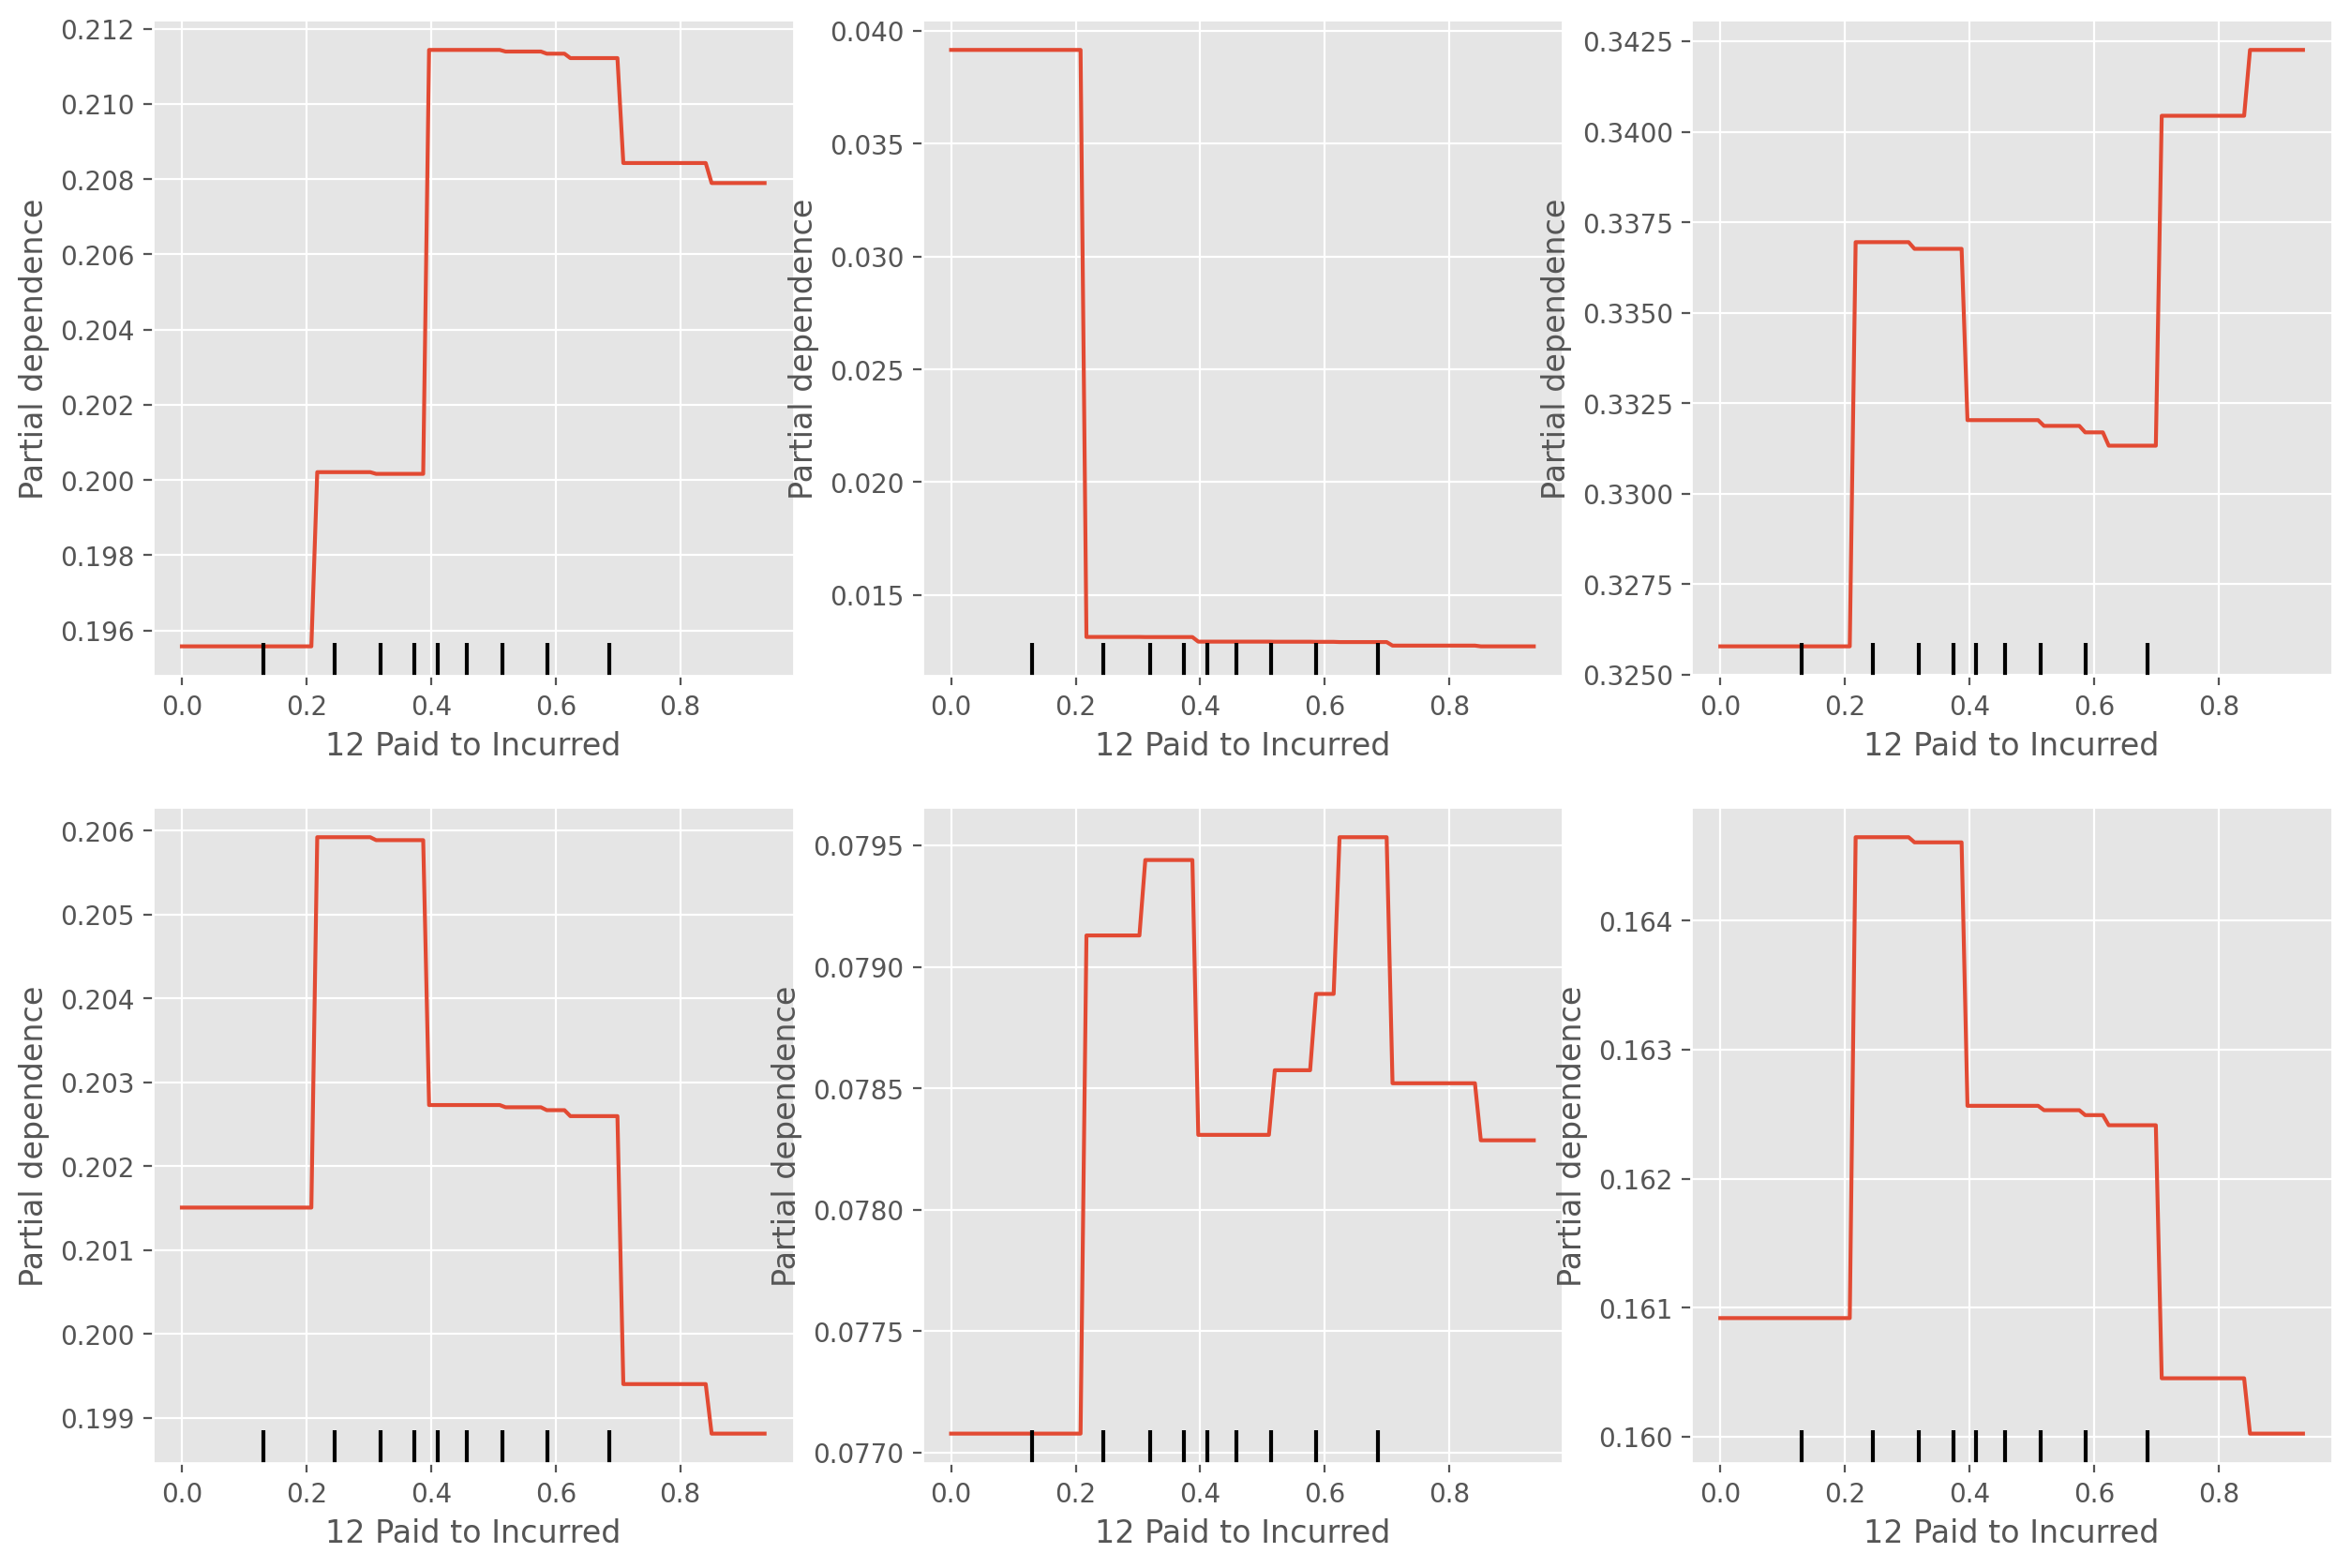

In [274]:
from sklearn.inspection import PartialDependenceDisplay

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
features=[list(gbm_grid.best_estimator_.feature_name_).index('12_Paid_to_Incurred')]

PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[0], ax=ax0)
PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[1], ax=ax1)
PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[2], ax=ax2)
PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[3], ax=ax3)
PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[4], ax=ax4)
PartialDependenceDisplay.from_estimator(gbm_grid.best_estimator_, X_train, features=features, target=[5], ax=ax5);


Note that the probabilities shown are approximately in line with the balance between these classes.

In [135]:
(pd.Series(le.inverse_transform(y_train)).value_counts() / len(y_train)).loc[le.classes_]

comauto     0.203098
medmal      0.046472
othliab     0.306368
ppauto      0.196213
prodliab    0.086059
wkcomp      0.161790
dtype: float64

For further research into model explainability, other packages exist that go much deeper.

[`lime` (Local Interpretable Model-agnostic Explanations)](https://github.com/marcotcr/lime) and [`shap` (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/) are two popular techniques used for explaining the predictions of machine learning models. They both aim to provide local interpretability, meaning they explain individual predictions of a model rather than its overall behavior. Both LIME and SHAP are powerful tools for understanding the behavior of complex machine learning models and gaining insights into the factors that drive individual predictions. They provide interpretability to models without compromising their predictive power, helping practitioners, users, and stakeholders trust and use AI systems more effectively and responsibly.

## Concluding Tips

1. Prioritize Feature Engineering above all else.
2. Hyperparameter tuning is important but usually provides marginal improvements over feature engineering in traditional ML space.
3. GBMs are a nice blend of power and ease-of-use. They should be your goto for most tabular data problems.
4. Always cross-validate. Your training scores are lying to you.
5. The baseline score you have to beat is not zero, its the NULL model.
6. Consider whether the default model performance metrics are appropriate for your specific task.
7. Use Pipelines to encapsulate multistep models. This reduces the risk of cross-contamination during cross-validation.

## AutoML

AutoML gets rid of a lot of the tedium that goes into experimentation.

In [ ]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data.reset_index().drop('GRNAME'. axis=1), target = 'LOB', session_id = 42)

In [ ]:
best = s.compare_models()

In [ ]:
print(best)

In [ ]:
tuned_model = s.tune_model(best)